### Link Prediction

Using tutorials from https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html and course lab sessions.

In [2]:
# Remove -q for verbose output
!pip install -q stellargraph==1.2.1 
!pip install -q chardet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [9]:
import stellargraph as sg
import pandas as pd

from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
from stellargraph.datasets import Cora

from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
wiki_nodes = pd.read_csv("../input/netsciprojectfiles/all_nodes_with_embeddings.csv").drop(columns=["Unnamed: 0"]).set_index("node_id")
wiki_nodes["lang"] = wiki_nodes["lang"].apply(lambda x: 0 if x == "en" else 1)
wiki_nodes = wiki_nodes[~wiki_nodes.index.duplicated(keep='first')]
wiki_nodes

,node_name,node_summary,interlanguagelink,lang,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,emb_1015,emb_1016,emb_1017,emb_1018,emb_1019,emb_1020,emb_1021,emb_1022,emb_1023,emb_1024
node_id,,,,,,,,,,,,,,,,,,,,,
27685,Tantra,Tantra (; ) refers to an esoteric yogic tr...,Tantrad,0,0.007162,-0.000021,0.008745,0.037631,0.002616,0.001703,...,0.005171,0.058880,0.003675,0.028359,-0.000763,0.006095,0.033892,0.007791,0.010625,0.057744
911,African Americans in Tennessee,African Americans are the second largest ethni...,NaN,0,0.038338,0.000166,0.026497,0.013443,0.005991,0.007938,...,0.037280,0.025509,-0.000958,0.054056,0.001076,-0.000418,0.049542,0.025684,0.017535,0.031755
13296,Hot in Cleveland (season 5),The fifth season of the TV Land original sitco...,NaN,0,0.033154,0.000338,-0.001907,0.027419,0.014966,0.004277,...,0.033737,0.000610,0.000457,0.028187,0.010877,0.005365,0.049015,0.024391,0.016312,0.013442
6720,Christopher Duggan,Christopher John Hesketh Duggan (4 November 19...,NaN,0,0.020830,-0.000012,0.007592,0.021195,0.001525,0.003835,...,0.061693,0.042112,0.001389,0.063940,0.000245,0.006784,0.018580,0.003010,0.013772,0.016922
26855,Spring and Autumn period,thumb|500px|right|Late Spring and Autumn perio...,NaN,0,0.029811,-0.000025,0.017157,0.021213,0.007252,0.019831,...,0.036601,0.010445,-0.000706,0.053638,-0.000131,0.001832,0.016317,0.018221,0.019031,0.023730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106641,Tomáš Rosický,pisi|Tomáš Rosický Tomáš Rosický (sündinud 4. ...,Tomáš Rosický,1,0.028258,0.003090,0.014844,0.029422,0.003937,0.003087,...,0.066677,0.039237,0.000789,0.108822,0.002360,0.005691,0.011021,-0.000413,-0.000168,-0.002332
103971,Laskuv põhjuslikkus,Laskuv põhjuslikkus (inglise downward causatio...,Downward causation,1,0.020266,-0.000011,-0.004387,0.043577,0.013558,0.009653,...,0.012333,0.009625,0.001342,0.025725,-0.000770,0.009964,0.025359,0.006405,0.011197,0.045270
102355,Francis Hutcheson,pisi|Allan Ramsay. Francis Hutchesoni portree...,Francis Hutcheson,1,0.001503,0.003898,0.000575,0.016381,0.012629,0.003515,...,0.034890,0.040253,0.004891,0.043037,-0.000987,0.008035,0.034557,0.012954,0.015181,0.035299


In [7]:
wiki_edges = pd.read_csv("../input/netsciprojectfiles/all_edges_interlanguage.csv").drop(columns=["Unnamed: 0"])
nodes_with_data = wiki_nodes.index
wiki_edges = wiki_edges[wiki_edges['source'].isin(nodes_with_data) & wiki_edges['target'].isin(nodes_with_data)]
wiki_edges

,source,target
0,103767,7598
1,106939,10922
2,106093,25533
3,103252,15335
4,106440,7313
...,...,...
83409,5237,6054
83410,5237,6064
83411,5237,6125
83412,5237,22836


In [10]:
G = StellarGraph(wiki_nodes.drop(columns=["node_name", "node_summary", "interlanguagelink"]), wiki_edges)

### Create a split for testing later

In [24]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.2 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 7130 positive and 7130 negative edges. **


### Sample training data

In [25]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 6417 positive and 6417 negative edges. **


In [26]:
print(G_train.info())
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 30767, Edges: 57757

 Node types:
  default: [30767]
    Features: float32 vector, length 1025
    Edge types: default-default->default

 Edge types:
    default-default->default: [57757]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 30767, Edges: 64174

 Node types:
  default: [30767]
    Features: float32 vector, length 1025
    Edge types: default-default->default

 Edge types:
    default-default->default: [64174]
        Weights: all 1 (default)
        Features: none


In [27]:
batch_size = 20
epochs = 20

num_samples = [20, 10]

train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

### Define model

In [28]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


### Untrained model sanity test

In [29]:
init_train_metrics = model.evaluate(train_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

642/642 [==============================] - 38s 57ms/step - loss: 0.9365 - acc: 0.5172

Train Set Metrics of the initial (untrained) model:
	loss: 0.9365
	acc: 0.5172


### Train model

In [35]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=1, workers=8)

Epoch 1/20
642/642 [==============================] - 144s 219ms/step - loss: 0.7786 - acc: 0.6282 - val_loss: 1.9581 - val_acc: 0.5000
Epoch 2/20
642/642 [==============================] - 131s 203ms/step - loss: 0.6706 - acc: 0.6516 - val_loss: 0.6176 - val_acc: 0.7104
Epoch 3/20
642/642 [==============================] - 131s 203ms/step - loss: 0.8420 - acc: 0.6068 - val_loss: 1.6798 - val_acc: 0.5003
Epoch 4/20
642/642 [==============================] - 141s 219ms/step - loss: 0.7054 - acc: 0.6141 - val_loss: 0.6891 - val_acc: 0.6776
Epoch 5/20
642/642 [==============================] - 141s 219ms/step - loss: 0.5665 - acc: 0.7227 - val_loss: 0.5760 - val_acc: 0.7276
Epoch 6/20
642/642 [==============================] - 132s 204ms/step - loss: 0.5284 - acc: 0.7433 - val_loss: 0.5172 - val_acc: 0.7569
Epoch 7/20
642/642 [==============================] - 128s 199ms/step - loss: 0.4895 - acc: 0.7723 - val_loss: 0.4854 - val_acc: 0.7745
Epoch 8/20
642/642 [============================

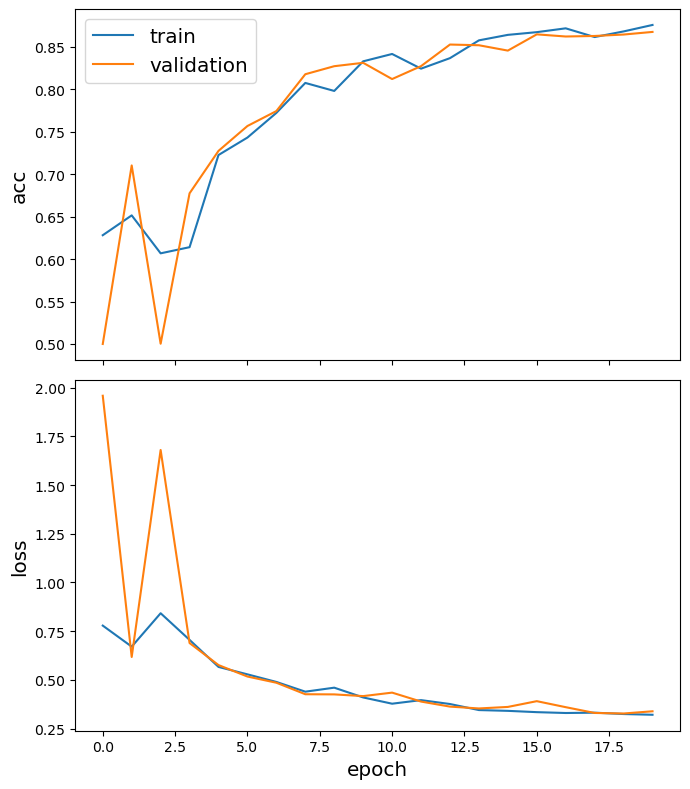

In [36]:
sg.utils.plot_history(history)
plt.savefig("modelhist.png", dpi=300)

In [37]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

713/713 [==============================] - 43s 61ms/step - loss: 0.3386 - acc: 0.8673

Train Set Metrics of the trained model:
	loss: 0.3011
	acc: 0.8761

Test Set Metrics of the trained model:
	loss: 0.3386
	acc: 0.8673


### Baseline

In [96]:
edge_ids_test

array([[ 17884,   3148],
       [100353, 100721],
       [   587,   3698],
       ...,
       [ 13732,   1495],
       [ 24033, 105096],
       [ 24777,  14713]])

In [117]:
from scipy.spatial import distance

similarities = []
for i, j in edge_ids_test:
    i_emb = wiki_nodes.iloc[wiki_nodes.index == i, 4:].values[0]
    j_emb = wiki_nodes.iloc[wiki_nodes.index == j, 4:].values[0]
    cosine_sim = 1 - distance.cosine(i_emb, j_emb)
    similarities.append(cosine_sim)

In [118]:
edge_ids_test, i, j

(array([[ 17884,   3148],
        [100353, 100721],
        [   587,   3698],
        ...,
        [ 13732,   1495],
        [ 24033, 105096],
        [ 24777,  14713]]),
 24777,
 14713)

In [119]:
baseline_df = pd.DataFrame({"sims": similarities, "linked_true": edge_labels_test})

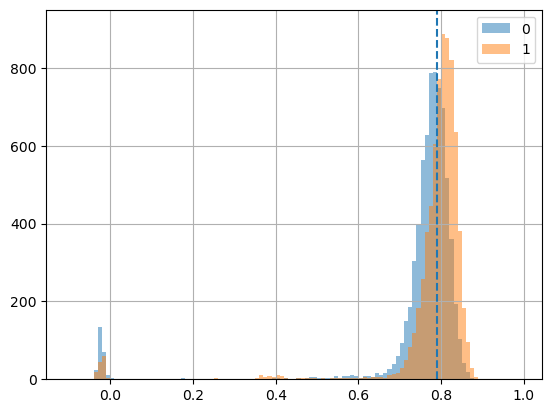

In [139]:
baseline_df.groupby("linked_true")["sims"].hist(bins=np.arange(-0.1, 1, 0.01), alpha=0.5, legend=True)
plt.vlines(0.79, 0, 1000, linestyles="dashed")
plt.ylim(0, 950)
plt.savefig("distributions.png", dpi=300)

In [123]:
thresh_accuracies = []
for i in np.arange(0, 1, 0.01):
    baseline_df["linked_pred"] = baseline_df["sims"] > i
    acc = (baseline_df["linked_pred"] == baseline_df["linked_true"]).sum() / len(baseline_df)
    thresh_accuracies.append(acc)

In [127]:
max(thresh_accuracies), np.arange(0, 1, 0.01)[thresh_accuracies.index(max(thresh_accuracies))]

(0.6405329593267882, 0.79)